Load libraries and data.

2025-04-03 20:29:58.441537: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-03 20:29:58.464950: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-03 20:29:58.494341: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-03 20:29:58.504007: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-03 20:29:58.526814: I tensorflow/core/platform/cpu_feature_guar

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


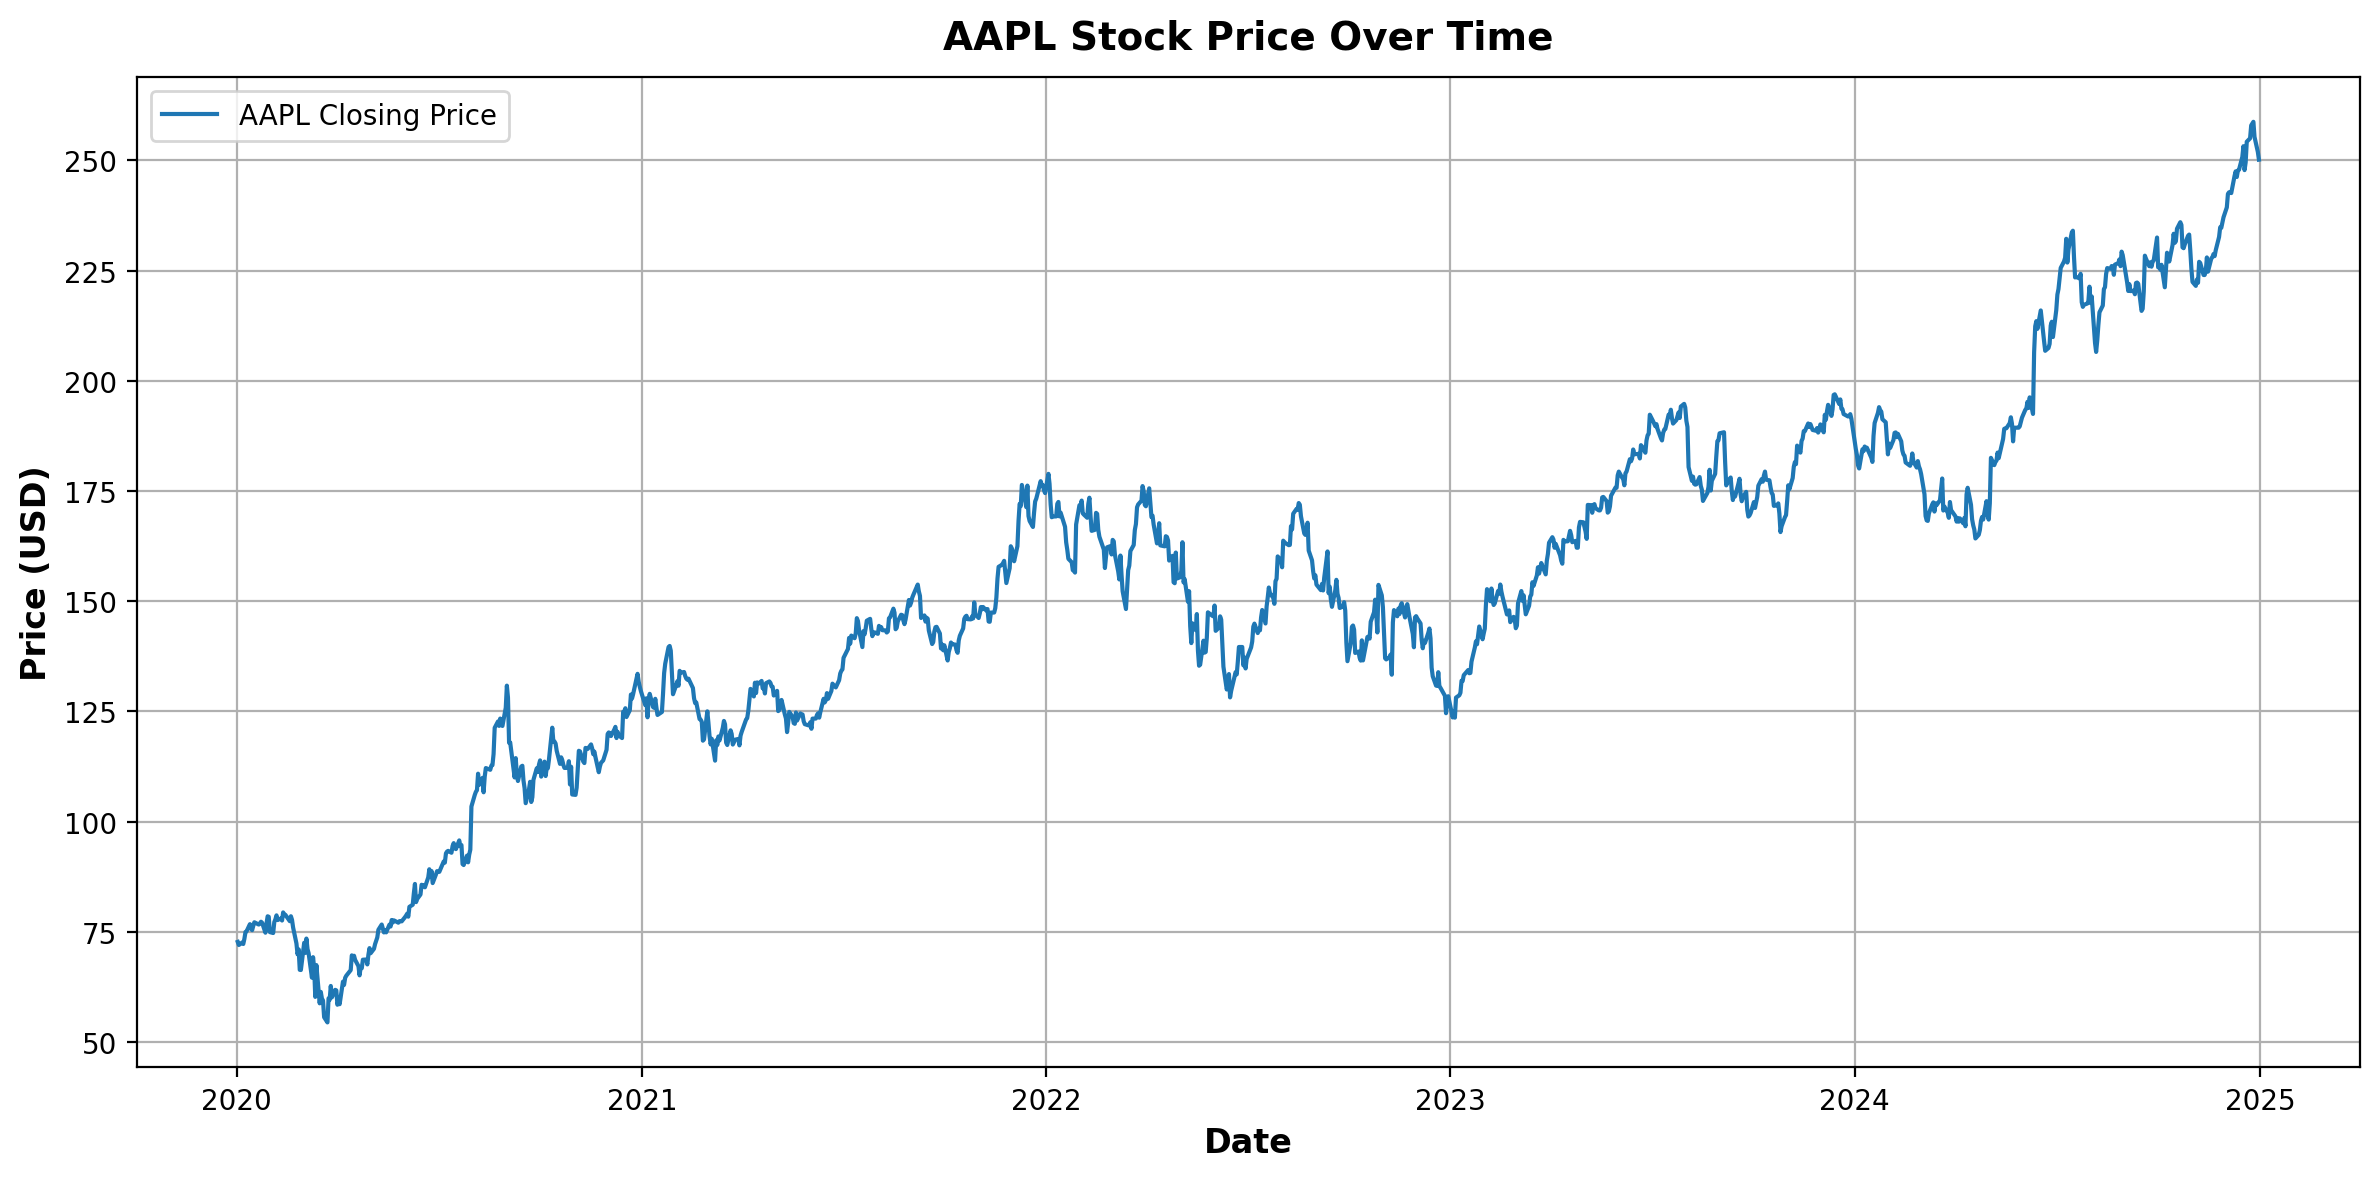

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Flatten, Input
from tensorflow.keras.optimizers import Adam
import yfinance as yf

import seaborn as sns

# Set Matplotlib defaults
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
%config InlineBackend.figure_format = 'retina'

# Create a folder for plots if it doesn't exist
os.makedirs("plots", exist_ok=True)

# Fetch Apple stock data
ticker = "AAPL"
start_date = "2020-01-01"
end_date = "2025-01-01"
data = yf.download(ticker, start=start_date, end=end_date)
data_pd_series = data['Close'].squeeze()  # Ensure y is a 1D Pandas Series

# Plot stock prices over time; closing price
plt.figure(figsize=(12, 6))
plt.plot(data['Close'], label=f"{ticker} Closing Price")
plt.title(f"{ticker} Stock Price Over Time")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.grid(True)
plt.legend()
plt.show()

For Linear Regression only

In [2]:
# ---------------- Linear Regression ----------------

# Prepare the target variable and lagged features
df_lr = pd.DataFrame({'y': data_pd_series})

# Dynamically create lagged features
num_lags = 5  # Specify the number of lags
for lag in range(1, num_lags + 1):
    df_lr[f'y_lag_{lag}'] = df_lr['y'].shift(lag)  # Create lagged columns

# Drop rows with NaN values (introduced by the lags)
df_lr = df_lr.dropna()

# Create features and target
X_lr = df_lr[[f'y_lag_{lag}' for lag in range(1, num_lags + 1)]]  # Features (time + lagged values)
y_lr = df_lr['y']  # Target (closing price)

# Align X and y to ensure no misalignment
y_lr, X_lr = y_lr.align(X_lr, join='inner')

# Train-test split (last 10 samples for testing)
num_test_samples = 10
X_lr_train, X_lr_test = X_lr.iloc[:-num_test_samples], X_lr.iloc[-num_test_samples:]
y_lr_train, y_lr_test = y_lr.iloc[:-num_test_samples], y_lr.iloc[-num_test_samples:]

# Train the model
model = LinearRegression()
model.fit(X_lr_train, y_lr_train)

# Make predictions on the training set
lr_train_preds = pd.Series(model.predict(X_lr_train), index=X_lr_train.index)

# Make many-step predictions using rolling updates for lagged features
lr_pred_list = []  # Store many-step predictions
lr_lag_values = X_lr_test.iloc[0, 1:].values  # Initialize with the last known lag values from the training set

for i in range(len(X_lr_test)):
    # Update the lagged features dynamically
    X_lr_test_row = np.concatenate(([X_lr_test.iloc[i, 0]], lr_lag_values))  # Combine time and lagged features
    # Convert to DataFrame with the same column names as X_lr_train
    X_lr_test_row_df = pd.DataFrame([X_lr_test_row], columns=X_lr_train.columns)
    lr_pred = model.predict(X_lr_test_row_df)[0]  # Predict the next value
    lr_pred_list.append(lr_pred)  # Store the prediction
    lr_lag_values = np.roll(lr_lag_values, -1)  # Shift lag values to the left
    lr_lag_values[-1] = lr_pred  # Add the new prediction as the most recent lag

# Convert the many-step predictions to a Pandas Series
lr_preds = pd.Series(lr_pred_list, index=X_lr_test.index)


For all the neural networks:

In [7]:
# Prepare the target variable and lagged features
df = pd.DataFrame({'y': data_pd_series})

# if scaled afterwords it seems to give a bug with lag_4 and above (wrong values)
# Scale the data
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Number of lag features
num_lags = 5
for lag in range(1, num_lags + 1):
    # df[f'y_lag_{lag}'] = df['y'].shift(lag)
    df_scaled[f'y_lag_{lag}'] = df_scaled['y'].shift(lag)

# Drop rows with NaN values (introduced by lagging)
df_scaled = df_scaled.dropna()

# Prepare features and target
X = df_scaled[[f'y_lag_{lag}' for lag in range(1, num_lags + 1)]]
y = df_scaled['y']

# Train-test split (last 10 samples for testing)
num_test_samples = 10
X_train, X_test = X.iloc[:-num_test_samples], X.iloc[-num_test_samples:]
y_train, y_test = y.iloc[:-num_test_samples], y.iloc[-num_test_samples:]

# ---------------- Rolling Predictions Function for networks----------------
def make_predictions(model, X_test, num_lags, nn_model=False):
    """
    Generate rolling predictions for a model using lagged features.
    It returns an array of predictions for the test set.
    It populates the lagged features dynamically (from predictions) and rolls them over.
    
    Parameters:
    - model: The trained model (Linear Regression, NN, LSTM, or GRU).
    - X_test: The test set features.
    - num_lags: Number of lagged features.
    - nn_model: Boolean indicating if the model is a feedforward NN (True) or not (False for RNN).
    
    Returns:
    - preds: Array of rolling predictions.
    """
    preds = []
    current_sequence = X_test.iloc[0].values.reshape(1, num_lags, 1)
    for _ in range(len(X_test)):
        # Predict the next value
        if nn_model==True:
            next_pred = model.predict(current_sequence, verbose=0)[0, 0, 0]
        else:
            next_pred = model.predict(current_sequence, verbose=0)[0, 0]
        preds.append(next_pred)
        
        # Roll over: Remove the oldest value and append the new prediction
        current_sequence = np.roll(current_sequence, -1, axis=1)
        current_sequence[0, -1, 0] = next_pred  # Update the last position with the new prediction

    return np.array(preds)

# ---------------- Neural Network ----------------
print("NN")
nn_model = Sequential([
    Input(shape=(num_lags, 1)),  # Explicitly define the input shape
    Dense(10, activation='relu'),  # Fully connected layer with 10 neurons
    Dense(1)  # Output layer
])

nn_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
nn_model.fit(X_train, y_train, epochs=50, batch_size=64, verbose=1)
#nn_train_preds = nn_model.predict(X_train, verbose=0)
nn_preds = make_predictions(nn_model, X_test, num_lags, True)
nn_train_preds = nn_model.predict(X_train)

# ---------------- LSTM ----------------
print("LSTM")
X_train_lstm = X_train.values.reshape(-1, num_lags, 1)
X_test_lstm = X_test.values.reshape(-1, num_lags, 1)
lstm_model = Sequential([
    Input(shape=(num_lags, 1)),  # Explicitly define the input shape
    LSTM(10, return_sequences=False),
    Dense(1)
])
lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
lstm_model.fit(X_train_lstm, y_train, epochs=50, batch_size=64, verbose=1)
#lstm_train_preds = lstm_model.predict(X_train, verbose=0)
lstm_preds = make_predictions(lstm_model, X_test, num_lags)

# ---------------- GRU ----------------
print("GRU")
gru_model = Sequential([
    Input(shape=(num_lags, 1)),  # Explicitly define the input shape
    GRU(10, return_sequences=False),
    Dense(1)
])
gru_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
gru_model.fit(X_train_lstm, y_train, epochs=50, batch_size=64, verbose=1)
#gru_train_preds = gru_model.predict(X_train, verbose=0)
gru_preds = make_predictions(gru_model, X_test, num_lags)

# Inverse transform predictions and actual values
y_test = scaler.inverse_transform(pd.DataFrame(y_test))
# training predictions
#nn_train_preds = scaler.inverse_transform(pd.DataFrame(nn_train_preds))
#lstm_train_preds = scaler.inverse_transform(pd.DataFrame(lstm_train_preds))
#gru_train_preds = scaler.inverse_transform(pd.DataFrame(gru_train_preds))
# actual predictions
nn_preds = scaler.inverse_transform(pd.DataFrame(nn_preds))
lstm_preds = scaler.inverse_transform(pd.DataFrame(lstm_preds))
gru_preds = scaler.inverse_transform(pd.DataFrame(gru_preds))

NN
Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2353  
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1469
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0813
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0454
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0245
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0145
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0107
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0101
Epoch 9/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0091
Epoch 10/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0091
Epoch 11/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0086
Epoch 12/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0088
Epoch 13/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0082
Epoch 14/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0075
Epoch 15/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0074
Epoch 16/50
20

ValueError: Exception encountered when calling Sequential.call().

[1mCannot take the length of shape with unknown rank.[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=<unknown>, dtype=float32)
  • training=False
  • mask=None

In [39]:
# set parameters:
epochs = 50
neurons = 20
learning_rate = 0.001
batch_size = 64

# Scale the data in [0,1]
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data[['Close']])

# Create sequences for models; these are lag features
def create_sequences(data, seq_length):
    sequences, targets = [], []
    for i in range(len(data) - seq_length):
        # append the #seq_length lags for data[i+seq_length]; input
        sequences.append(data[i:i+seq_length])
        # add the target value of data[i+seq_length]; output
        targets.append(data[i+seq_length])
    return np.array(sequences), np.array(targets)

# number of lags to be included
seq_length = 5
X, y = create_sequences(data_scaled, seq_length)# input, output

# remove the last days days from the training set; well check predictions on them
train_size = int(len(X) - 10)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Train the LSTM model
print("Training LSTM model...")
# Define the LSTM model
lstm_model = Sequential([
    Input(shape=(num_lags, 1)),  # Explicitly define the input shape
    LSTM(neurons, return_sequences=True),
    LSTM(neurons, return_sequences=False),
    Dense(1)
])
lstm_model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
# train the model
lstm_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

# Make predictions with the LSTM model
# apply trained model on training data
lstm_train_preds = lstm_model.predict(X_train)

# Make future predictions with the LSTM model
# the 1st prediction needs to be used to generate the future lags and roll them over
lstm_rolling_preds = []

# Start with the last sequence from the test set
lstm_current_sequence = X_test[0].reshape(1, seq_length, 1)  # Reshape to match LSTM input shape

for _ in range(len(X_test)):
    # Predict the next value
    next_pred = lstm_model.predict(lstm_current_sequence, verbose=0)[0, 0]
    lstm_rolling_preds.append(next_pred)
    
    # Roll over: Remove the oldest value and append the new prediction
    lstm_current_sequence = np.roll(lstm_current_sequence, -1, axis=1)
    lstm_current_sequence[0, -1, 0] = next_pred  # Update the last position with the new prediction

# Inverse transform the rolling predictions, from [0,1] to their original range
lstm_test_preds = scaler.inverse_transform(np.array(lstm_rolling_preds).reshape(-1, 1))

# Inverse transform the predictions and actual values
lstm_train_preds = scaler.inverse_transform(lstm_train_preds)

###########################################################################################
# Train the GRU model
print("Training GRU model...")
# Define the GRU model
gru_model = Sequential([
    Input(shape=(num_lags, 1)),  # Explicitly define the input shape
    GRU(neurons, return_sequences=True),  # GRU layer with 10 units
    GRU(neurons, return_sequences=False),  # GRU layer with 10 units
    Dense(1)  # Output layer
])
gru_model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')

# Train the GRU model
gru_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

# Make predictions with the GRU model
# Apply trained model on training data
gru_train_preds = gru_model.predict(X_train)

# Make future predictions with the GRU model
gru_rolling_preds = []

# Start with the last sequence from the test set
gru_current_sequence = X_test[0].reshape(1, seq_length, 1)  # Reshape to match GRU input shape

for _ in range(len(X_test)):
    # Predict the next value
    next_pred = gru_model.predict(gru_current_sequence, verbose=0)[0, 0]
    gru_rolling_preds.append(next_pred)
    
    # Roll over: Remove the oldest value and append the new prediction
    gru_current_sequence = np.roll(gru_current_sequence, -1, axis=1)
    gru_current_sequence[0, -1, 0] = next_pred  # Update the last position with the new prediction

# Inverse transform the rolling predictions, from [0,1] to their original range
gru_test_preds = scaler.inverse_transform(np.array(gru_rolling_preds).reshape(-1, 1))

# Inverse transform the predictions and actual values
gru_train_preds = scaler.inverse_transform(gru_train_preds)

# Train the Simple Sequential Neural Network
nn_model = Sequential([
    Input(shape=(num_lags, 1)),  # Explicitly define the input shape
    Flatten(),
    Dense(5, activation='relu'),  # Fully connected layer with 5 neurons
    Dense(neurons, activation='relu'),
    Dense(1)  # Output layer
])
nn_model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')

###########################################################################################
# Train the NN model
print("Training NN model...")
# Define the NN model
nn_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

# Make predictions with the NN model
# Apply trained model on training data
nn_train_preds = nn_model.predict(X_train)

# Make future predictions with the NN model
nn_rolling_preds = []

# Start with the last sequence from the test set
nn_current_sequence = X_test[0].reshape(1, seq_length, 1)  # Reshape to match NN input shape

for _ in range(len(X_test)):
    # Predict the next value
    next_pred = nn_model.predict(nn_current_sequence, verbose=0)[0, 0]
    nn_rolling_preds.append(next_pred)
    
    # Roll over: Remove the oldest value and append the new prediction
    nn_current_sequence = np.roll(nn_current_sequence, -1, axis=1)
    nn_current_sequence[0, -1, 0] = next_pred  # Update the last position with the new prediction

# Inverse transform the rolling predictions, from [0,1] to their original range
nn_test_preds = scaler.inverse_transform(np.array(nn_rolling_preds).reshape(-1, 1))

# Inverse transform the predictions and actual values
nn_train_preds = scaler.inverse_transform(np.array(nn_train_preds))

# inverse transform targets for plots later
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))


Training LSTM model...
Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.2154
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0441
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0127
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0072
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0048
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0030
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0016
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0010
Epoch 9/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 8.0463e-04
Epoch 10/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 7.1775e-04
Epoch 11/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 7.1487e-04
Epoch 12/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 7.0177e-04
Epoch 13/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 6.6714e-04
Epoch 14/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 6.4255e-04
Epoch 15/50
20/20 ━━━━━━

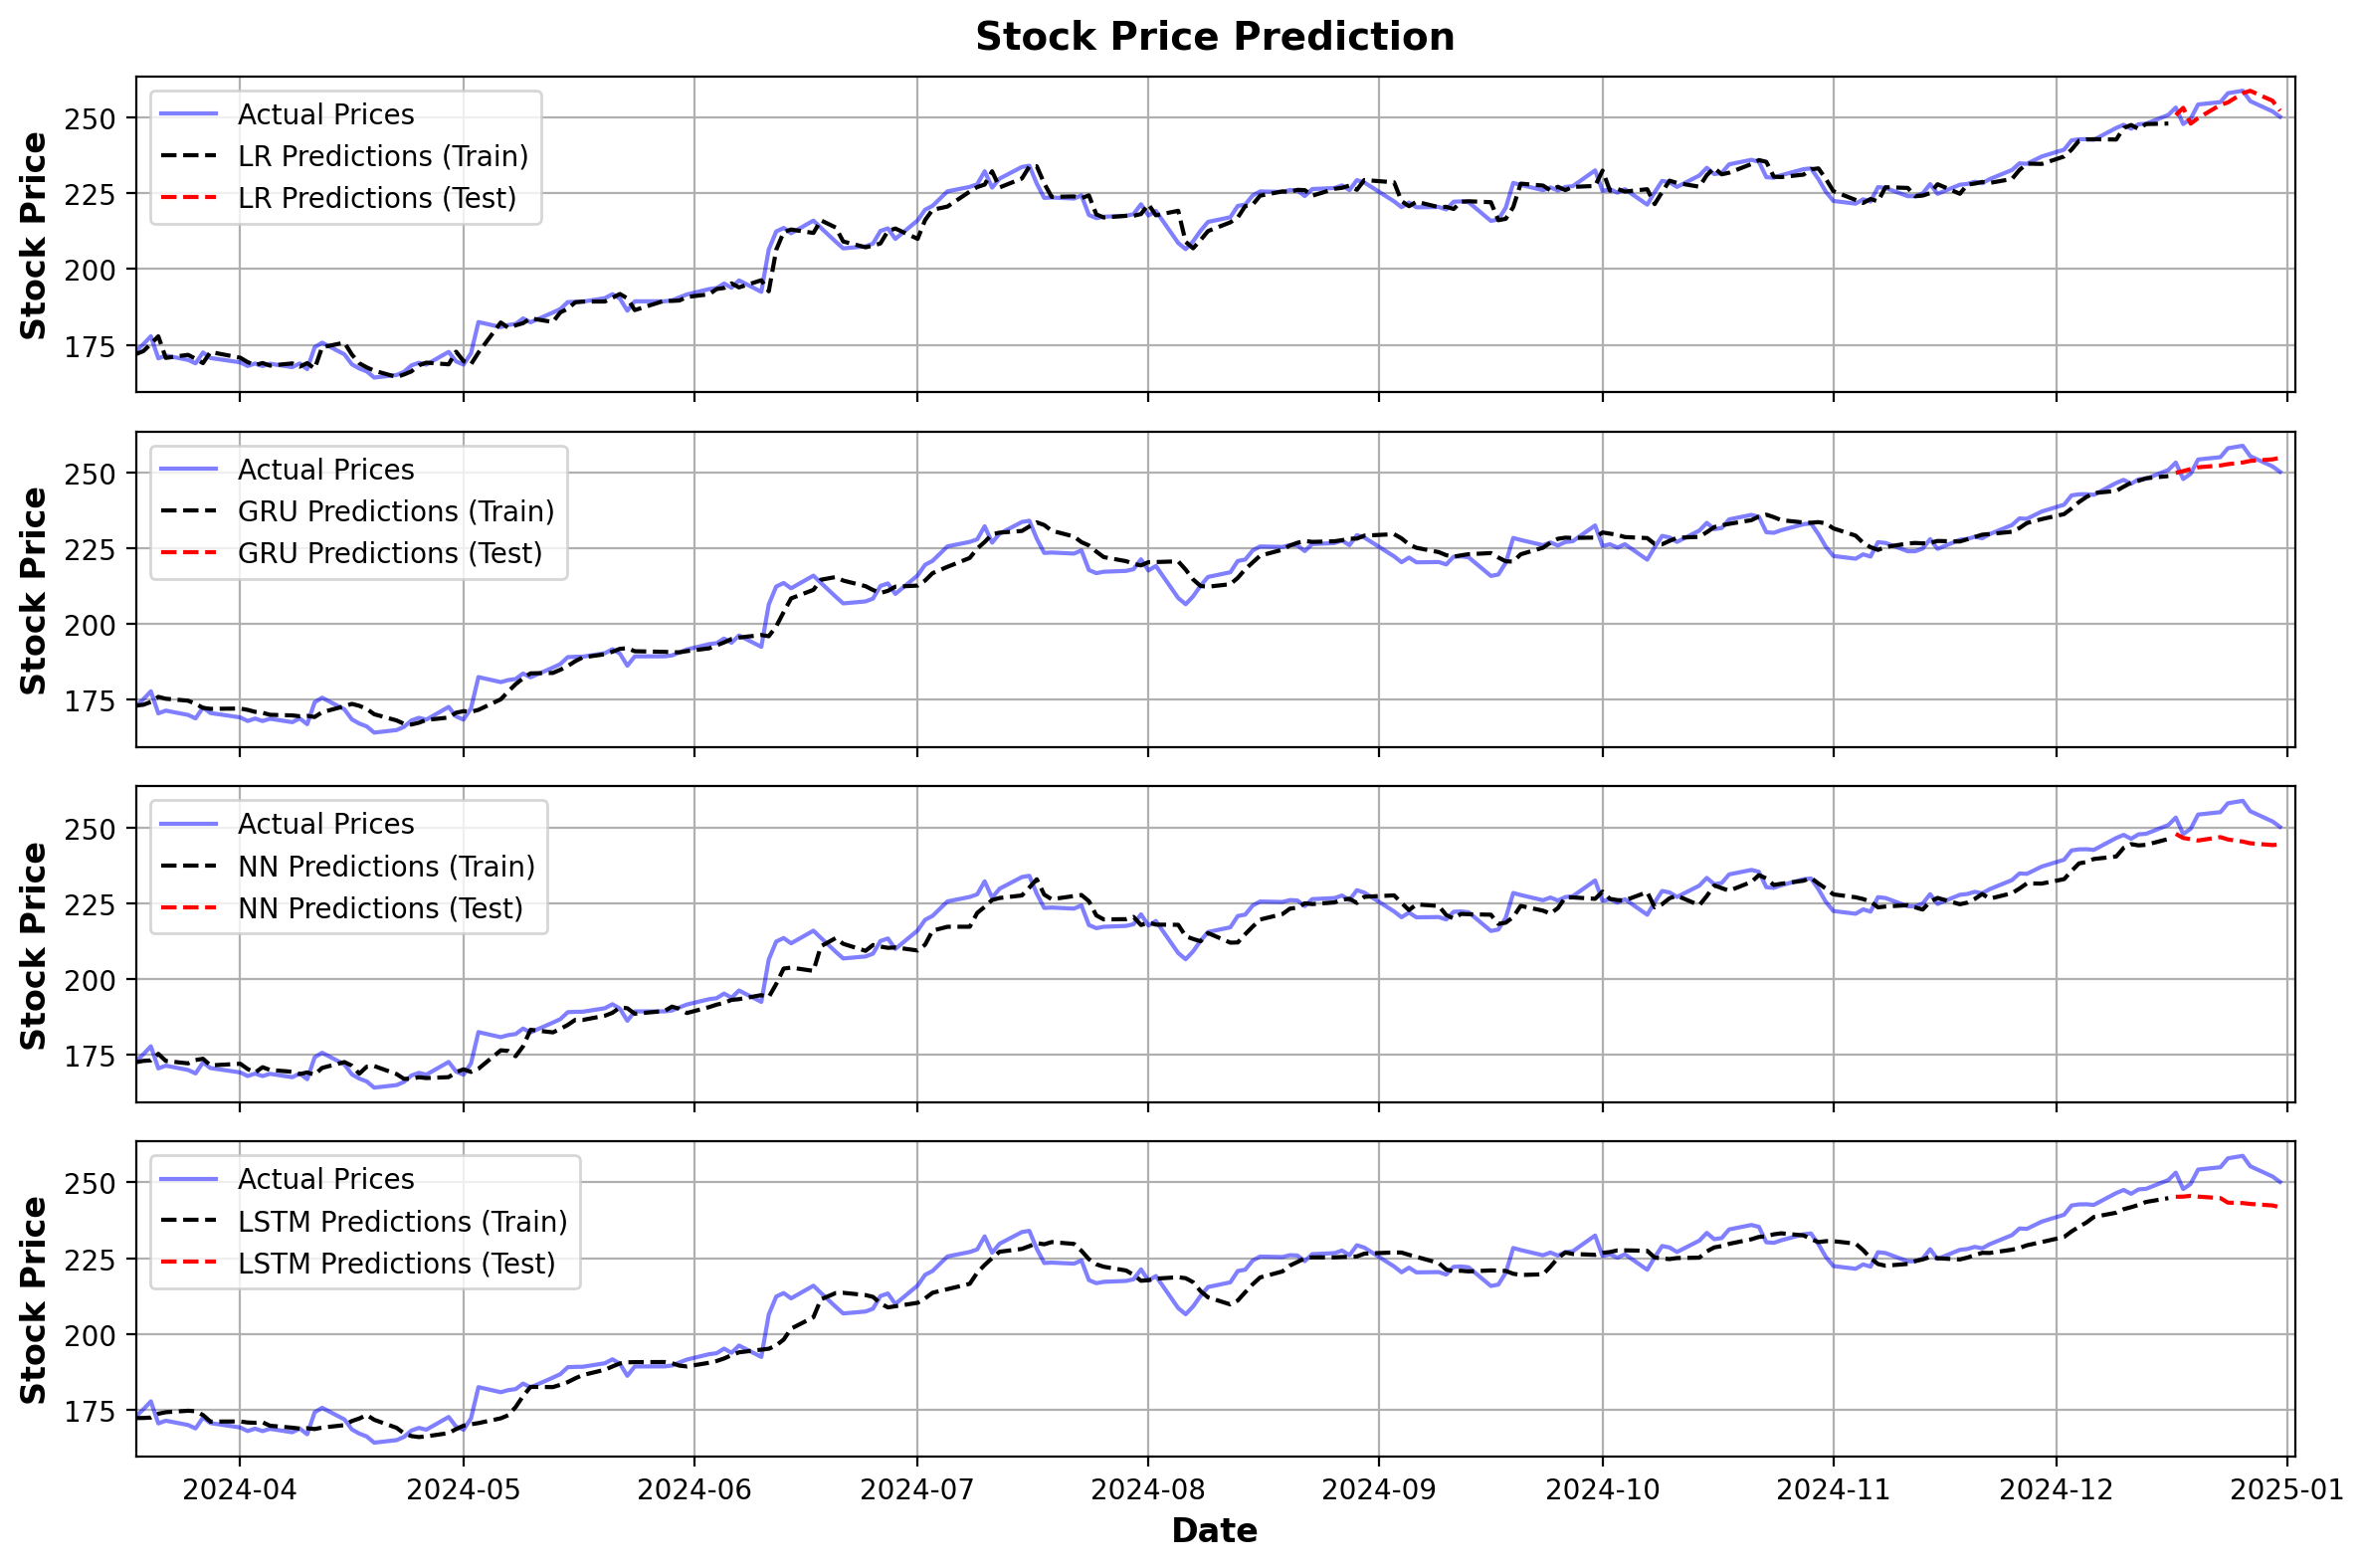

LR MSE (Train): 7.07
LR MSE (Test): 9.59
LSTM MSE (Train): 19.58
LSTM MSE (Test): 103.83
GRU MSE (Train): 13.41
GRU MSE (Test): 12.22
NN MSE (Train): 14.43
NN MSE (Test): 71.13


In [61]:
# Define zoom-in indices
i = -200  # Start index for zooming (e.g., last 200 points)
j = None  # End index for zooming (use None for the end of the data)

# Get the starting and ending dates
start_date = data.index[i]  # Start date based on zoom-in index
end_date = data.index[j - 1] if j is not None else data.index[-1]  # End date (last date in the data)
end_date_with_buffer = end_date + pd.Timedelta(days=2)  # Add 2 days as a buffer

# Create subplots
fig, axes = plt.subplots(4, 1, figsize=(12, 8))  # 4 rows, 1 column

# Plot LR results
axes[0].plot(data.index[i:j], np.concatenate((y_lr_train, y_lr_test))[i:j], label="Actual Prices", color="blue", alpha=0.5)
axes[0].plot(data.index[seq_length:train_size+seq_length][i+10:j], lr_train_preds[i+10:j], label="LR Predictions (Train)", color="black", linestyle="--")
axes[0].plot(data.index[train_size+seq_length:][i:j], lr_preds[i:j], label="LR Predictions (Test)", color="red", linestyle="--")
axes[0].legend()
axes[0].set_title("Stock Price Prediction")
axes[0].set_ylabel("Stock Price")
axes[0].grid(True, axis='x')  # Keep vertical grid lines
axes[0].grid(True, axis='y')  # Keep vertical grid lines
axes[0].tick_params(axis='x', labelbottom=False)  # Remove x-axis tick labels
axes[0].set_xlim([start_date, end_date_with_buffer])  # Set x-axis limits

# Plot GRU results
axes[1].plot(data.index[i:j], np.concatenate((y_train, y_test))[i:j], label="Actual Prices", color="blue", alpha=0.5)
axes[1].plot(data.index[seq_length:train_size+seq_length][i+10:j], gru_train_preds[i+10:j], label="GRU Predictions (Train)", color="black", linestyle="--")
axes[1].plot(data.index[train_size+seq_length:][i:j], gru_test_preds[i:j], label="GRU Predictions (Test)", color="red", linestyle="--")
axes[1].legend()
axes[1].set_ylabel("Stock Price")
axes[1].grid(True, axis='x')  # Keep vertical grid lines
axes[1].grid(True, axis='y')  # Keep vertical grid lines
axes[1].tick_params(axis='x', labelbottom=False)  # Remove x-axis tick labels
axes[1].set_xlim([start_date, end_date_with_buffer])  # Set x-axis limits

# Plot Simple Sequential NN results
axes[2].plot(data.index[i:j], np.concatenate((y_train, y_test))[i:j], label="Actual Prices", color="blue", alpha=0.5)
axes[2].plot(data.index[seq_length:train_size+seq_length][i+10:j], nn_train_preds[i+10:j], label="NN Predictions (Train)", color="black", linestyle="--")
axes[2].plot(data.index[train_size+seq_length:][i:j], nn_test_preds[i:j], label="NN Predictions (Test)", color="red", linestyle="--")
axes[2].legend()
axes[2].set_ylabel("Stock Price")
axes[2].grid(True, axis='x')  # Keep vertical grid lines
axes[2].grid(True, axis='y')  # Keep vertical grid lines
axes[2].tick_params(axis='x', labelbottom=False)  # Remove x-axis tick labels
axes[2].set_xlim([start_date, end_date_with_buffer])  # Set x-axis limits

# Plot LSTM results
axes[3].plot(data.index[i:j], np.concatenate((y_train, y_test))[i:j], label="Actual Prices", color="blue", alpha=0.5)
axes[3].plot(data.index[seq_length:train_size+seq_length][i+10:j], lstm_train_preds[i+10:j], label="LSTM Predictions (Train)", color="black", linestyle="--")
axes[3].plot(data.index[train_size+seq_length:][i:j], lstm_test_preds[i:j], label="LSTM Predictions (Test)", color="red", linestyle="--")
axes[3].legend()
axes[3].set_ylabel("Stock Price")
axes[3].grid(True, axis='x')  # Keep vertical grid lines
axes[3].grid(True, axis='y')  # Keep vertical grid lines
axes[3].tick_params(axis='x', labelbottom=True)  # Remove x-axis tick labels
axes[3].set_xlabel("Date")  # Keep x-axis label only for the last plot
axes[3].set_xlim([start_date, end_date_with_buffer])  # Set x-axis limits

# Adjust layout
plt.tight_layout()

# Save the figure as a PNG file in the "plots" directory
import os
os.makedirs("../plots", exist_ok=True)  # Create the directory if it doesn't exist
plt.savefig("../plots/stock_price_predictions.png", dpi=300)  # Save the figure with high resolution

plt.show()

# Evaluate and print MSE for all models
lr_train_rmse = (mean_squared_error(y_train, lr_train_preds))
lr_test_rmse = (mean_squared_error(y_test, lr_preds))
print(f"LR MSE (Train): {lr_train_rmse:.2f}")
print(f"LR MSE (Test): {lr_test_rmse:.2f}")

lstm_train_rmse = (mean_squared_error(y_train, lstm_train_preds))
lstm_test_rmse = (mean_squared_error(y_test, lstm_test_preds))
print(f"LSTM MSE (Train): {lstm_train_rmse:.2f}")
print(f"LSTM MSE (Test): {lstm_test_rmse:.2f}")

gru_train_rmse = (mean_squared_error(y_train, gru_train_preds))
gru_test_rmse = (mean_squared_error(y_test, gru_test_preds))
print(f"GRU MSE (Train): {gru_train_rmse:.2f}")
print(f"GRU MSE (Test): {gru_test_rmse:.2f}")

nn_train_rmse = (mean_squared_error(y_train, nn_train_preds))
nn_test_rmse = (mean_squared_error(y_test, nn_test_preds))
print(f"NN MSE (Train): {nn_train_rmse:.2f}")
print(f"NN MSE (Test): {nn_test_rmse:.2f}")